# Loan Default Prediction - Classification

## Part 1. Exploratory Data Analysis

**This notebook contains code for:**
1. **Investigation of the impact of loan defaults on the simple return of a sample portfolio,**
2. **EDA of loan data.**

---

<a id ='toc'></a>
**Table of Contents**

1. [Sample portolio data:](#portfolio) what is the challenge? default impact

2. [Data overview:](#overview)
    1. [Basic information](#overview)
    2. [Distributions](#dist)
        1. [Categorical features](#dist)
        2. [Numerical features](#num)
    3. [Segmentation & Correlations](#seg)
        1. [cat vs. target](#seg)
        2. [correlations](#corr)

3. [Notes](#notes)
---

In [70]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', 200)
pd.set_option('max_rows', 200)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

import math

<a id = 'portfolio'></a>
### 1. Sample portfolio data

In [2]:
# load a sample of an investor's portfolio
df_port = pd.read_csv('./data/portfolio_loan_datav20200116.csv', low_memory = False)

In [3]:
df_port.shape

(369, 176)

In [4]:
df_port.head()

,LoanId,OrderId,PortfolioId,NoteId,PortfolioName,Invested,InterestRate,Grade,LoanType,Term,PrincipalRemaining,Trend,NoteType,Accrual,PaymentsReceivedToDate,NextPaymentDate,Status,Note Issue Date,OrderDate,LoanStatusDate,Pending Principal Payment,Pending Interest,Purchased,installment,emp_title,emp_length,home_ownership,annual_inc,is_inc_v,accept_d,exp_d,list_d,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,acc_now_delinq,acc_open_past_24mths,bc_open_to_buy,percent_bc_gt_75,bc_util,dti,delinq_2yrs,delinq_amnt,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,mths_since_recent_inq,mths_since_recent_revol_delinq,mths_since_recent_bc,mort_acc,open_acc,pub_rec,total_bal_ex_mort,revol_bal,revol_util,total_bc_limit,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,total_il_high_credit_limit,num_rev_accts,mths_since_recent_bc_dlq,pub_rec_bankruptcies,num_accts_ever_120_pd,chargeoff_within_12_mths,collections_12_mths_ex_med,tax_liens,mths_since_last_major_derog,num_sats,num_tl_op_past_12m,mo_sin_rcnt_tl,tot_hi_cred_lim,tot_cur_bal,avg_cur_bal,num_bc_tl,num_actv_bc_tl,num_bc_sats,pct_tl_nvr_dlq,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_il_tl,mo_sin_old_il_acct,num_actv_rev_tl,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,total_rev_hi_lim,num_rev_tl_bal_gt_0,num_op_rev_tl,tot_coll_amt,Loan Issue Date,1st Month Payment,application_type,annual_inc_joint,dti_joint,verification_status_joint,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,inq_fi,total_cu_tl,inq_last_12m,PURCHASE_PRINCIPAL,PURCHASE_INTEREST,PRINCIPAL_RECEIVED,INTEREST_RECEIVED,LATE_FEES_RECEIVED,ORIGINAL_ASSET_AMOUNT,ORIGINAL_CONTRACTUAL_DUE_D,NEW_DUE_D,COUNT_PAY_DAY,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,HARDSHIP_FLAG,HARDSHIP_TYPE,HARDSHIP_REASON,HARDSHIP_STATUS,DEFERRAL_TERM,HARDSHIP_AMOUNT,HARDSHIP_START_DATE,HARDSHIP_END_DATE,PAYMENT_PLAN_START_DATE,HARDSHIP_LENGTH,HARDSHIP_DPD,HARDSHIP_LOAN_STATUS,ORIG_PROJECTED_ADDITIONAL_ACCRUED_INTEREST,HARDSHIP_PAYOFF_BALANCE_AMOUNT,HARDSHIP_LAST_PAYMENT_AMOUNT,DISBURSEMENT_METHOD,DEBT_SETTLEMENT_FLAG,DEBT_SETTLEMENT_FLAG_DATE,SETTLEMENT_STATUS,SETTLEMENT_DATE,SETTLEMENT_AMOUNT,SETTLEMENT_PERCENTAGE,SETTLEMENT_TERM
0,84987305,122733953,None,134440812,None,25.0,26.490000000000002%,F2,Personal,36,0.000000,DOWN,1,0.000000,30.478042,08/03/2017,Fully Paid,08/05/2016,08/02/2016,07/12/2017,0.0,0.0,0,145.99,NaN,NaN,OWN,25000.0,Verified,2016-07-27,2016-09-01,2016-08-02,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,271xx,NC,0,9,1491.0,33.3,61.8,23.62,0,0,2006-01-26,680,684,1,NaN,NaN,0.0,NaN,6.0,0,9,0,12232,4366,41.6%,3900,14,f,0.00,0.00,4388.838009,4388.84,3600.00,788.84,0.0,0.00,0.0000,2017-07-12,2934.24,NaN,2019-11-14,679,675,8145,10,NaN,0,0,0,0,0,NaN,9,7,0,18645,12232,1359,6,2,3,100.0,0,0,0.0,4,37.0,3,126,0,10500,3,7,83,08/03/2016,NaN,Individual,NaN,NaN,NaN,6,2,3,3,1.0,7866,97.0,4,6,1660,66,0,0,1,25,0,25.000000,5.478042,0.0,25,3,,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,85241901,122776613,None,134609040,None,25.0,22.39%,E1,Personal,60,11.533055,DOWN,1,0.229994,27.902919,01/15/2020,Current,08/09/2016,08/04/2016,01/10/2020,0.0,0.0,0,336.19,Funeral Director/ Embalmer,6 years,MORTGAGE,59000.0,Source Verified,2016-08-03,2016-09-03,2016-08-04,n,https://lendingclu

In [5]:
df_port.Status.value_counts()

Fully Paid            203
Charged Off           110
Current                47
Late (31-120 days)      7
Late (16-30 days)       1
Default                 1
Name: Status, dtype: int64

In [6]:
# only definite loan status are relevant to our analysis
df_port = df_port.loc[df_port.Status.isin(['Fully Paid', 'Charged Off'])]
df_port.shape

(313, 176)

In [7]:
df_port.Status.value_counts()

Fully Paid     203
Charged Off    110
Name: Status, dtype: int64

In [8]:
df_port.loc[:, 'Status'] = df_port.Status.replace({'Fully Paid':0, 'Charged Off':1})
df_port.Status.mean()

0.3514376996805112

In [9]:
df_port.groupby('Grade')['Status'].agg(['count', 'mean'])

,count,mean
Grade,,
D2,8,0.250000
D3,12,0.500000
D4,28,0.428571
D5,30,0.233333
E1,61,0.196721
E2,57,0.385965
E3,51,0.392157
E4,38,0.394737
E5,25,0.520000


In [10]:
df_port[['Invested', 'PaymentsReceivedToDate', 'PrincipalRemaining']].sum()

Invested                  7825.000000
PaymentsReceivedToDate    7519.223252
PrincipalRemaining        2114.759242
dtype: float64

**Notes:**
- Variation in default rate within each grade
- Higher grade doesn't guarantee higher default rate, e.g., D3, D4, D5, E1, in this particular porfolio
- Even at F1, F2 grade, some loans are fully paid off
- target_col = 'Status'

**Challenge:**
- The sample portfolio's loan default rate is 35%, however, the loss due to default is so large that the portfolio as a whole is at a net loss, using simple interest.
- The statstics provided by Lendingclub.com (https://www.lendingclub.com/info/demand-and-credit-profile.action) also suggests similar insight: the average interest rate for all loans issued so far is ~13%, but net annualized return is only 5%, default loans significantly affect all loan performance.
- Poor portfolio performance is bad news for both responsible borrowers and lenders:
    - for lenders: loosing interest in P2P market, feels personal when someone doesn't pay back, allocate assets elsewhere
    - for responsible borrowers: suffers unfair bad reputation caused by irresponsible borrowers even though the majority borrowers are responsible
    - especially for responsible borrowers with low credit score: lose access to capital that is otherwise not available to them

**So, the question is: Can we avoid irresponsible borrowers with the data given?**
**Goal: using model trained on old loan data to predict default probability on new data**



[back to top](#toc)

<a id = 'overview'></a>
### 2. Data overview
#### 2.A. Basic information

In [11]:
# load raw loan data
%%time
df = pd.read_csv('./data/master_loan_datav2019q3.csv', low_memory = False)

CPU times: user 1min 49s, sys: 15.1 s, total: 2min 4s
Wall time: 2min 3s


In [12]:
df.shape

(2650518, 150)

In [13]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,1077501,NaN,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,735.0,739.0,1.0,NaN,NaN,3.0,0.0,13648.0,83.7%,9.0,f,0.0,0.0,5863.155187,5833.84,5000.00,863.16,0.00,0.0,0.00,Jan-2015,171.62,NaN,May-2019,714.0,710.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,NaN,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-1999,740.0,744.0,5.0,NaN,NaN,3.0,0.0,1687.0,9.4%,4.0,f,0.0,0.0,1014.530000,1014.53,456.46,435.17,0.00,122.9,1.11,Apr-2013,119.66,NaN,Oct-2016,499.0,0.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,N

In [14]:
df.tail()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
2650513,153709478,NaN,23300.0,23300.0,23300.0,60 months,22.50%,650.17,D,D3,Service Representative,10+ years,MORTGAGE,60000.0,Not Verified,Jul-2019,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,336xx,FL,30.00,0.0,Aug-2000,695.0,699.0,0.0,NaN,NaN,19.0,0.0,24776.0,37.9%,31.0,w,22422.52,22422.52,2571.56,2571.56,877.48,1694.08,0.0,0.0,0.0,Nov-2019,650.17,Dec-2019,Nov-2019,719.0,715.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,302149.0,0.0,2.0,2.0,2.0,10.0,25944.0,76.0,1.0,1.0,9113.0,51.0,65300.0,1.0,1.0,3.0,3.0,16786.0,11039.0,55.3,0.0,0.0,114.0,226.0,10.0,10.0,2.0,10.0,NaN,2.0,NaN,1.0,2.0,4.0,4.0,7.0,8.0,15.0,21.0,4.0,19.0,0.0,0.0,0.0,3.0,96.8,25.0,0.0,0.0,357545.0,50720.0,24700.0,34245.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2650514,153714644,NaN,20000.0,20000.0,20000.0,60 months,20.00%,529.88,D,D2,Teen director,7 years,MORTGAGE,55000.0,Not Verified,Jul-2019,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,home_improvement,Home improvement,681xx,NE,25.73,0.0,Jul-1992,730.0,734.0,0.0,NaN,NaN,7.0,0.0,9773.0,82.1%,13.0,w,19193.94,19193.94,2097.30,2097.30,806.06,1291.24,0.0,0.0,0.0,Nov-2019,529.88,Dec-2019,Nov-2019,729.0,725.0,0.0,NaN,1.0,Joint App,145000.0,27.47,Not Verified,0.0,0.0,48490.0,0.0,4.0,0.0,2.0,14.0,38717.0,73.0,0.0,1.0,6329.0,75.0,11900.0,1.0,2.0,0.0,3.0,6927.0,1627.0,85.7,0.0,0.0,154.0,323.0,24.0,14.0,0.0,24.0,NaN,15.0,NaN,0.0,2.0,2.0,2.0,3.0,9.0,3.0,4.0,2.0,7.0,0.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0

In [15]:
df.dtypes

id                                             object
member_id                                     float64
loan_amnt                                     float64
funded_amnt                                   float64
funded_amnt_inv                               float64
term                                           object
int_rate                                       object
installment                                   float64
grade                                          object
sub_grade                                      object
emp_title                                      object
emp_length                                     object
home_ownership                                 object
annual_inc                                    float64
verification_status                            object
issue_d                                        object
loan_status                                    object
pymnt_plan                                     object
url                         

In [16]:
%%time
df.describe().transpose()

CPU times: user 26.9 s, sys: 3.92 s, total: 30.8 s
Wall time: 16.7 s


,count,mean,std,min,25%,50%,75%,max
member_id,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_amnt,2650517.0,15265.709011,9389.330623,5.000000e+02,8000.0000,13000.000000,20000.0000,4.000000e+04
funded_amnt,2650517.0,15261.216557,9387.905730,5.000000e+02,8000.0000,13000.000000,20000.0000,4.000000e+04
funded_amnt_inv,2650517.0,15245.323518,9391.762630,0.000000e+00,8000.0000,13000.000000,20000.0000,4.000000e+04
installment,2650517.0,450.393110,271.041190,4.930000e+00,253.2700,380.760000,601.3300,1.719830e+03
annual_inc,2650513.0,79076.829903,112047.909393,0.000000e+00,46819.0000,65000.000000,95000.0000,1.100000e+08
dti,2647892.0,19.094297,15.248854,-1.000000e+00,11.9700,17.960000,24.7000,9.990000e+02
delinq_2yrs,2650488.0,0.296115,0.853387,0.000000e+00,0.0000,0.000000,0.0000,5.800000e+01
fico_range_low,2650517.0,699.824574,33.478428,6.100000e+02,675.0000,690.000000,715.0000,8.450000e+02
fico_range_high,2650517.0,703.824779,33.479321,6.140000e+02,679.0000,694.000000,719.0000,8.500000e+02


In [17]:
target_col = 'loan_status'

In [18]:
df = df.loc[df[target_col].isin(['Fully Paid', 'Charged Off']), :]

In [19]:
df.shape

(1641691, 150)

In [20]:
df.loan_status.value_counts()

Fully Paid     1319751
Charged Off     321940
Name: loan_status, dtype: int64

In [25]:
df.loan_status.value_counts()[1]/df.shape[0]

0.19610267705676646

[back to top](#toc)

<a id = 'dist'></a>
### 2.B. Distribution
#### 2.B.a. Categorical features

In [26]:
cat_cols = df.dtypes[df.dtypes == 'object'].index.tolist()
print(len(cat_cols))
cat_cols

39


['id',
 'term',
 'int_rate',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'earliest_cr_line',
 'revol_util',
 'initial_list_status',
 'last_pymnt_d',
 'next_pymnt_d',
 'last_credit_pull_d',
 'application_type',
 'verification_status_joint',
 'sec_app_earliest_cr_line',
 'hardship_flag',
 'hardship_type',
 'hardship_reason',
 'hardship_status',
 'hardship_start_date',
 'hardship_end_date',
 'payment_plan_start_date',
 'hardship_loan_status',
 'debt_settlement_flag',
 'debt_settlement_flag_date',
 'settlement_status',
 'settlement_date']

In [27]:
%%time
df.describe(include = 'object').transpose()

CPU times: user 18.7 s, sys: 981 ms, total: 19.7 s
Wall time: 18.5 s


,count,unique,top,freq
id,1641691,1641691,78983256,1
term,1641691,2,36 months,1236279
int_rate,1641691,672,10.99%,41673
grade,1641691,7,B,481775
sub_grade,1641691,35,C1,104852
emp_title,1530728,424549,Teacher,26766
emp_length,1540954,11,10+ years,540878
home_ownership,1641691,6,MORTGAGE,811629
verification_status,1641691,3,Source Verified,644333
issue_d,1641691,148,Mar-2016,56388


In [56]:
cat_col_stats = df.describe(include = 'object').transpose()
cat_col_chart = cat_col_stats[(cat_col_stats['unique']>0) & 
                              (cat_col_stats['unique']<52)].index.tolist()
len(cat_col_chart)

23

In [57]:
cat_col_chart

['term',
 'grade',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'loan_status',
 'pymnt_plan',
 'purpose',
 'addr_state',
 'initial_list_status',
 'application_type',
 'verification_status_joint',
 'hardship_flag',
 'hardship_type',
 'hardship_reason',
 'hardship_status',
 'hardship_start_date',
 'hardship_end_date',
 'payment_plan_start_date',
 'hardship_loan_status',
 'debt_settlement_flag',
 'settlement_status']

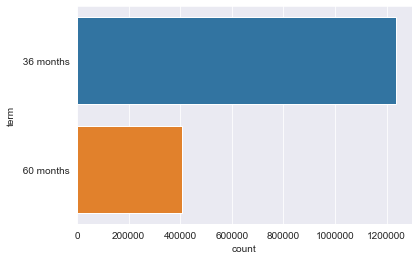

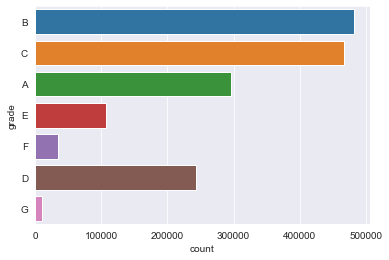

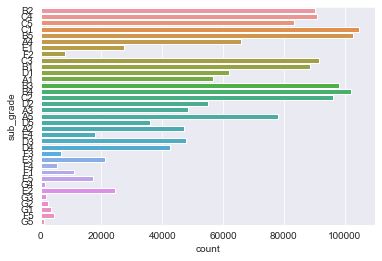

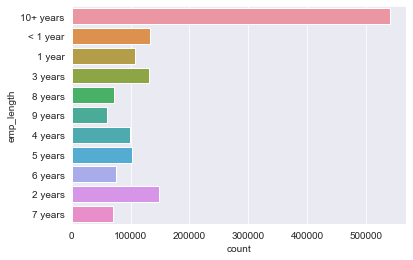

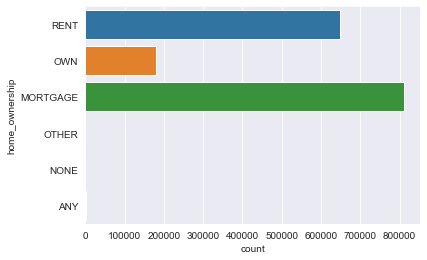

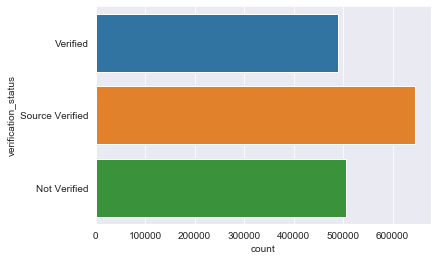

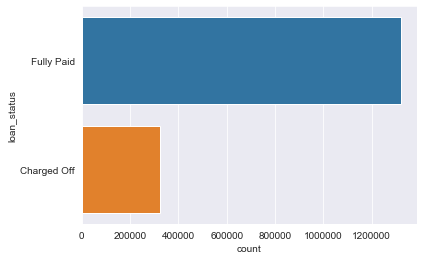

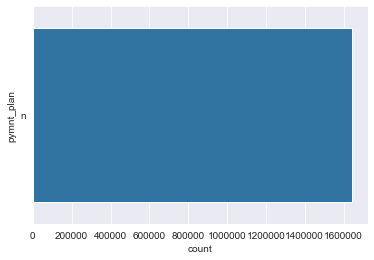

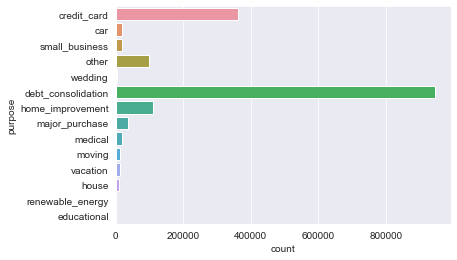

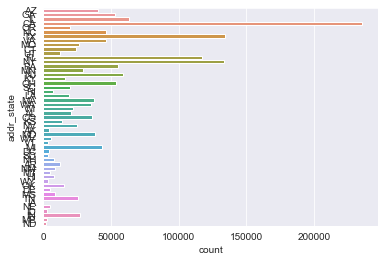

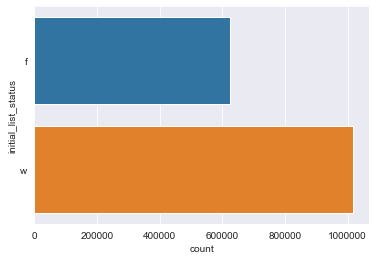

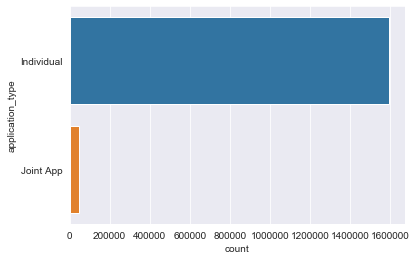

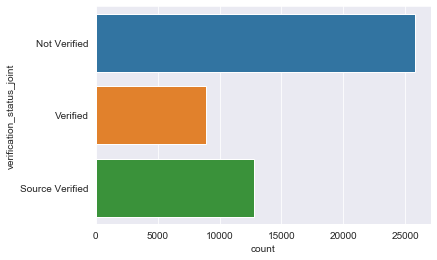

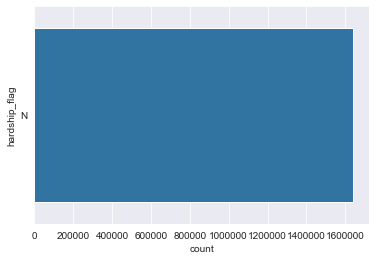

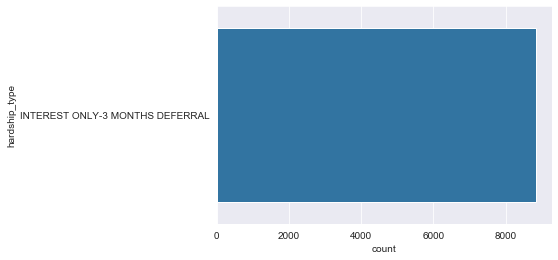

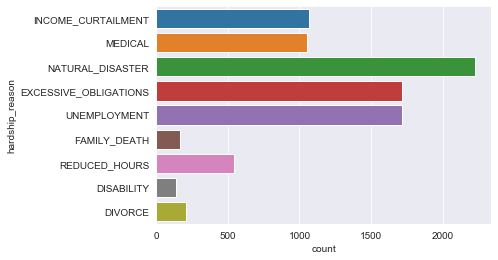

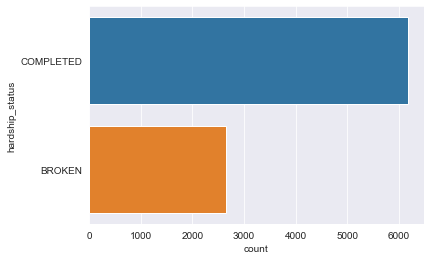

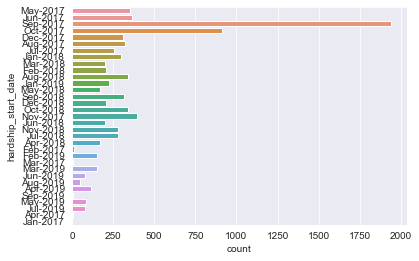

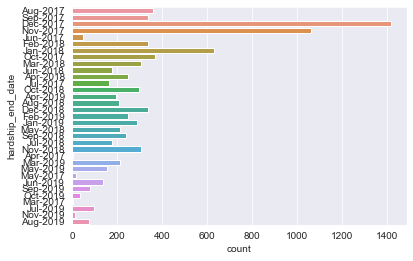

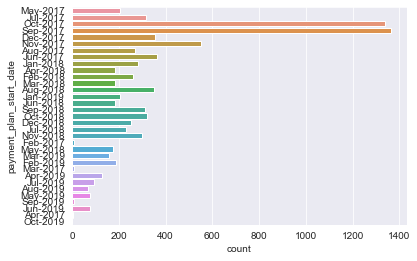

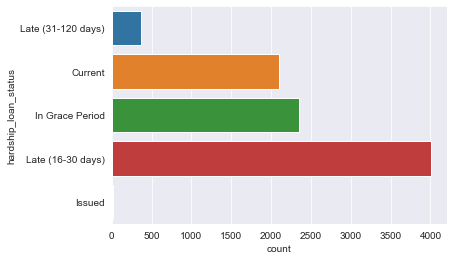

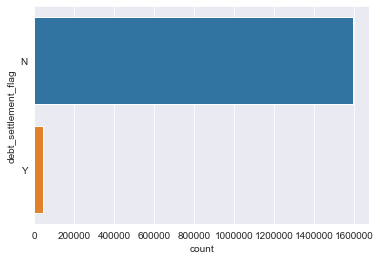

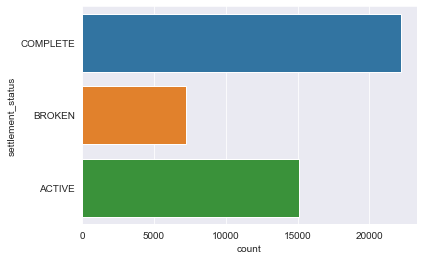

In [58]:
for col in cat_col_chart:
    sns.countplot(y = col, data= df)
    plt.show()

[back to top](#toc)

<a id = 'num'></a>
#### 2.B.b. Numerical Features

In [61]:
num_cols = df.dtypes[df.dtypes != 'object'].index.tolist()
print (len(num_cols))
num_cols

111


['member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'installment',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'total_acc',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_amnt',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'annual_inc_joint',
 'dti_joint',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_uti

In [64]:
%%time
df.describe().transpose()

CPU times: user 16.5 s, sys: 2.49 s, total: 19 s
Wall time: 11.1 s


,count,mean,std,min,25%,50%,75%,max
member_id,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_amnt,1641691.0,14519.268273,8862.580688,5.000000e+02,8000.000000,12000.00,20000.000000,4.000000e+04
funded_amnt,1641691.0,14512.361187,8859.488727,5.000000e+02,7975.000000,12000.00,20000.000000,4.000000e+04
funded_amnt_inv,1641691.0,14493.084890,8861.267146,0.000000e+00,7850.000000,12000.00,20000.000000,4.000000e+04
installment,1641691.0,439.447092,264.720655,4.930000e+00,247.530000,374.31,583.510000,1.719830e+03
annual_inc,1641691.0,76877.677854,112479.023993,0.000000e+00,46000.000000,65000.00,91000.000000,1.100000e+08
dti,1640927.0,18.446216,12.362823,-1.000000e+00,11.810000,17.67,24.190000,9.990000e+02
delinq_2yrs,1641691.0,0.316177,0.878717,0.000000e+00,0.000000,0.00,0.000000,4.200000e+01
fico_range_low,1641691.0,697.007671,32.346360,6.250000e+02,670.000000,690.00,715.000000,8.450000e+02
fico_range_high,1641691.0,701.007827,32.347076,6.290000e+02,674.000000,694.00,719.000000,8.500000e+02


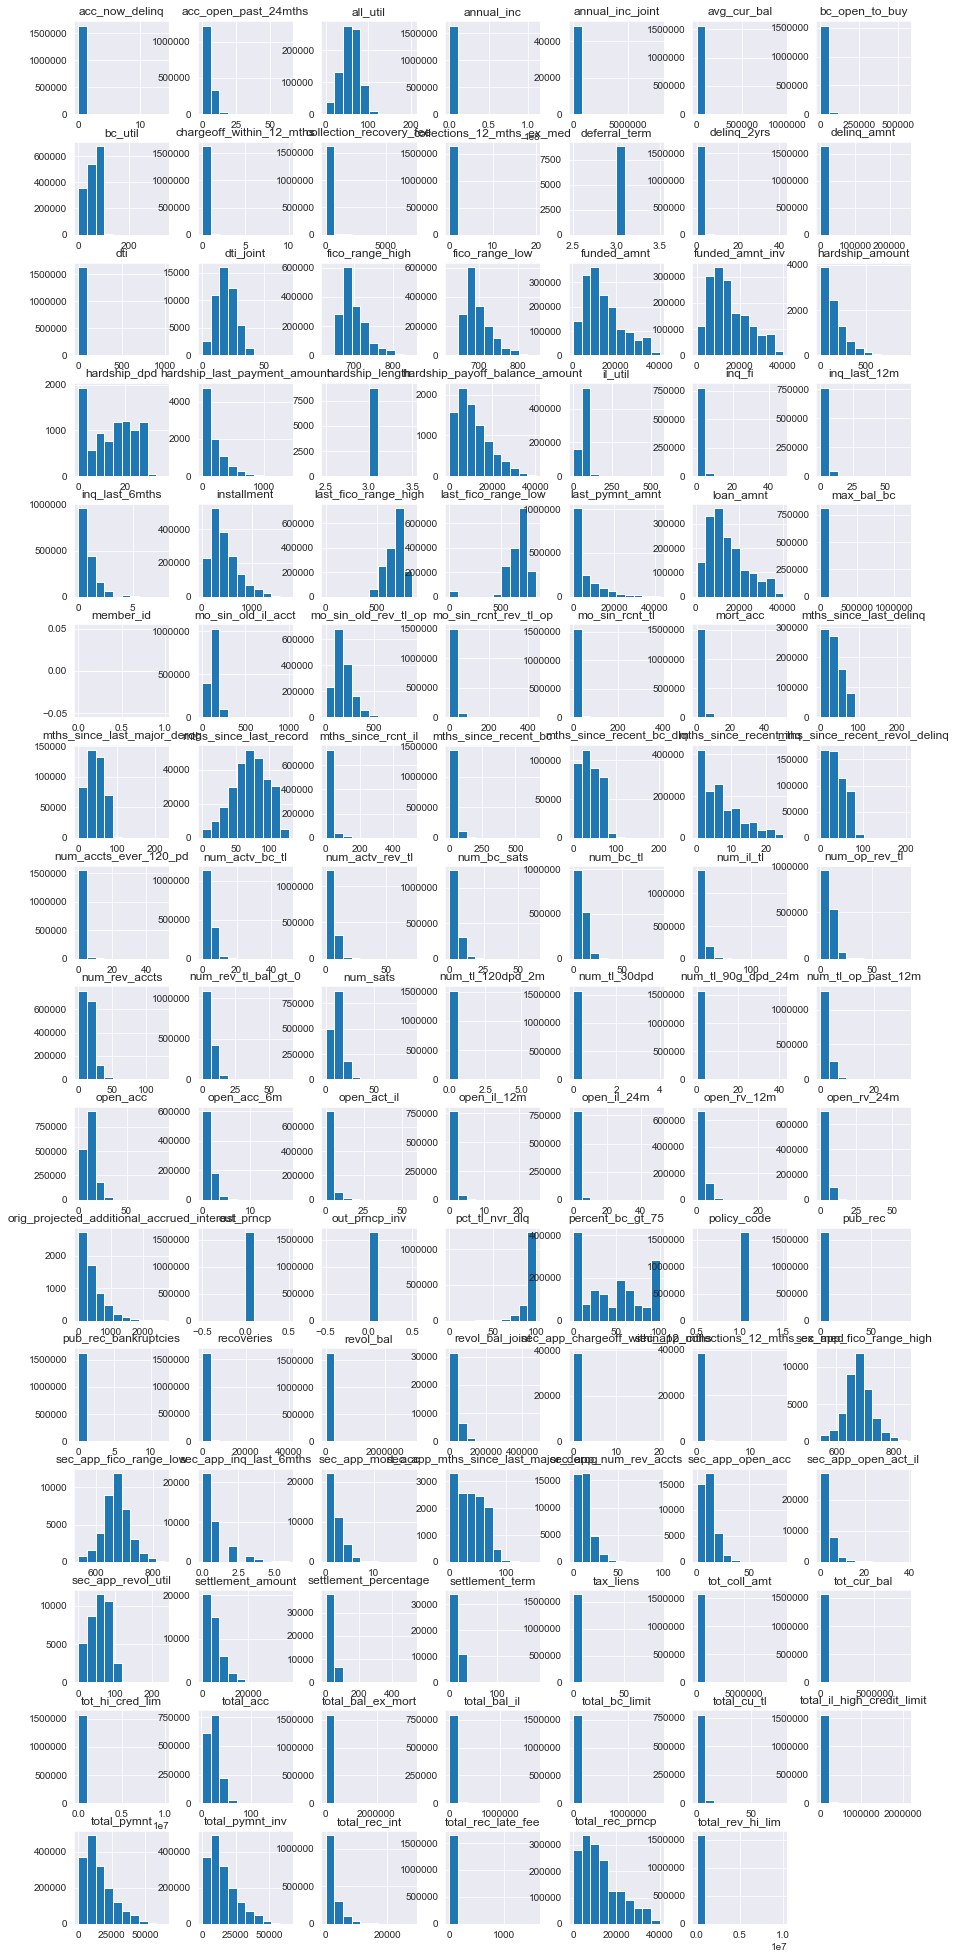

CPU times: user 52.8 s, sys: 1.28 s, total: 54.1 s
Wall time: 49.2 s


In [119]:
# bar plot for numerical features
%%time
df.hist(xlabelsize = 10, layout = (16, 7), figsize = (15,35))
plt.show()

[back to top](#toc)

<a id = 'seg'></a>
### 2.C. Segmentation & Correlation
#### 2.C.a. cat vs. target

In [121]:
df.loc[:, 'loan_status'] = df.loan_status.replace({'Fully Paid': 0, 'Charged Off': 1})
df.loan_status.head()

0    0
1    1
2    0
3    0
4    0
Name: loan_status, dtype: int64

In [123]:
df.groupby('grade')['loan_status'].mean()

grade
A    0.061769
B    0.134085
C    0.222934
D    0.300399
E    0.379209
F    0.447485
G    0.494800
Name: loan_status, dtype: float64

In [125]:
df.groupby('sub_grade')['loan_status'].mean()

sub_grade
A1    0.033244
A2    0.048391
A3    0.057999
A4    0.070837
A5    0.085252
B1    0.105066
B2    0.115170
B3    0.130367
B4    0.148001
B5    0.165465
C1    0.187808
C2    0.205675
C3    0.223988
C4    0.247580
C5    0.258974
D1    0.274600
D2    0.289360
D3    0.303445
D4    0.321343
D5    0.332696
E1    0.350840
E2    0.365993
E3    0.383325
E4    0.398314
E5    0.418038
F1    0.418092
F2    0.446679
F3    0.447846
F4    0.475688
F5    0.488986
G1    0.474631
G2    0.484368
G3    0.503670
G4    0.513589
G5    0.534496
Name: loan_status, dtype: float64

In [126]:
df.groupby(['addr_state'])['loan_status'].agg(['mean', 'count'])

,mean,count
addr_state,,
AK,0.193356,3853
AL,0.231172,20236
AR,0.235657,12323
AZ,0.192103,40067
CA,0.194977,235612
CO,0.151492,36048
CT,0.175143,24500
DC,0.134545,4073
DE,0.191978,4662


In [127]:
df.groupby('purpose')['loan_status'].agg(['mean', 'count'])

,mean,count
purpose,,
car,0.143122,17831
credit_card,0.168230,361023
debt_consolidation,0.207484,944740
educational,0.171254,327
home_improvement,0.173855,108723
house,0.220440,9413
major_purchase,0.185424,36554
medical,0.210494,19535
moving,0.225956,11635


In [129]:
df.groupby('emp_length')[['loan_status']].agg(['mean', 'count'])

loan_status        
                  mean   count
emp_length                    
1 year        0.201410  108073
10+ years     0.183038  540878
2 years       0.194601  148499
3 years       0.197218  131418
4 years       0.195945   98681
5 years       0.193596  102285
6 years       0.189999   75732
7 years       0.191939   70236
8 years       0.194739   71429
9 years       0.192287   60602
< 1 year      0.205092  133121

In [130]:
df.groupby('home_ownership')['loan_status'].agg(['mean', 'count'])

,mean,count
home_ownership,,
ANY,0.170243,699
MORTGAGE,0.169081,811629
NONE,0.142857,49
OTHER,0.187500,144
OWN,0.202385,179949
RENT,0.228177,649221


In [131]:
df.groupby('initial_list_status')[['loan_status']].agg(['mean', 'count'])

loan_status         
                           mean    count
initial_list_status                     
f                      0.193620   623335
w                      0.197622  1018356

[back to top](#toc)

<a id = 'corr'></a>
#### 2.C.b. correlations

In [133]:
corr = df.corr()
corr

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,loan_status,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
member_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_amnt,NaN,1.000000,0.999652,0.998861,0.952379,0.195032,0.069787,0.035799,-0.004056,0.100470,0.100470,-0.016569,-0.019008,0.006549,0.183093,-0.061867,0.316182,0.204970,NaN,NaN,0.857482,0.857092,0.798152,0.621933,0.093221,0.191128,0.185050,0.494606,0.047821,0.043234,-0.019052,-0.002260,NaN,0.305715,0.066023,0.001053,-0.003821,0.312179,-0.014953,0.028439,0.001540,0.028761,-0.016224,0.149327,-0.081469,-0.034245,-0.019738,0.345901,0.002848,0.317417,0.005295,0.071137,0.017219,0.008254,0.227187,0.198188,0.052241,-0.001400,0.000721,0.121667,0.161976,0.045693,0.023527,0.222597,0.029823,-0.037834,-0.000336,-0.030489,-0.050284,0.193550,0.151179,0.213492,0.197100,0.077903,0.164350,0.168711,0.150440,0.180594,-0.000848,0.002298,-0.021580,-0.020821,0.088036,0.022613,-0.088805,0.007692,0.334002,0.273917,0.367317,0.201359,0.353443,0.185523,0.185523,-0.056895,0.170319,0.208774,0.029530,0.056845,0.188456,-0.044299,-0.070050,0.090999,NaN,0.705859,NaN,0.045332,0.704436,0.839905,0.499612,0.798647,-0.047853,0.213330
funded_amnt,NaN,0.999652,1.000000,0.999281,0.952893,0.194988,0.069824,0.036097,-0.003900,0.099808,0.099808,-0.016791,-0.019028,0.006420,0.183341,-0.061673,0.316111,0.204910,NaN,NaN,0.857685,0.857359,0.798416,0.621799,0.093290,0.191252,0.185230,0.494900,0.047630,0.043077,-0.018967,-0.002258,NaN,0.305716,0.066029,0.001103,-0.003820,0.312179,-0.014952,0.028441,0.001540,0.028763,-0.016224,0.149328,-0.081467,-0.034244,-0.019736,0.345901,0.002848,0.317417,0.005296,0.071138,0.017220,0.008256,0.227187,0.198195,0.052235,-0.001336,0.000736,0.121668,0.161976,0.045694,0.023527,0.222597,0.029821,-0.037834,-0.000334,-0.030486,-0.050285,0.193550,0.151179,0.213491,0.197

In [134]:
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

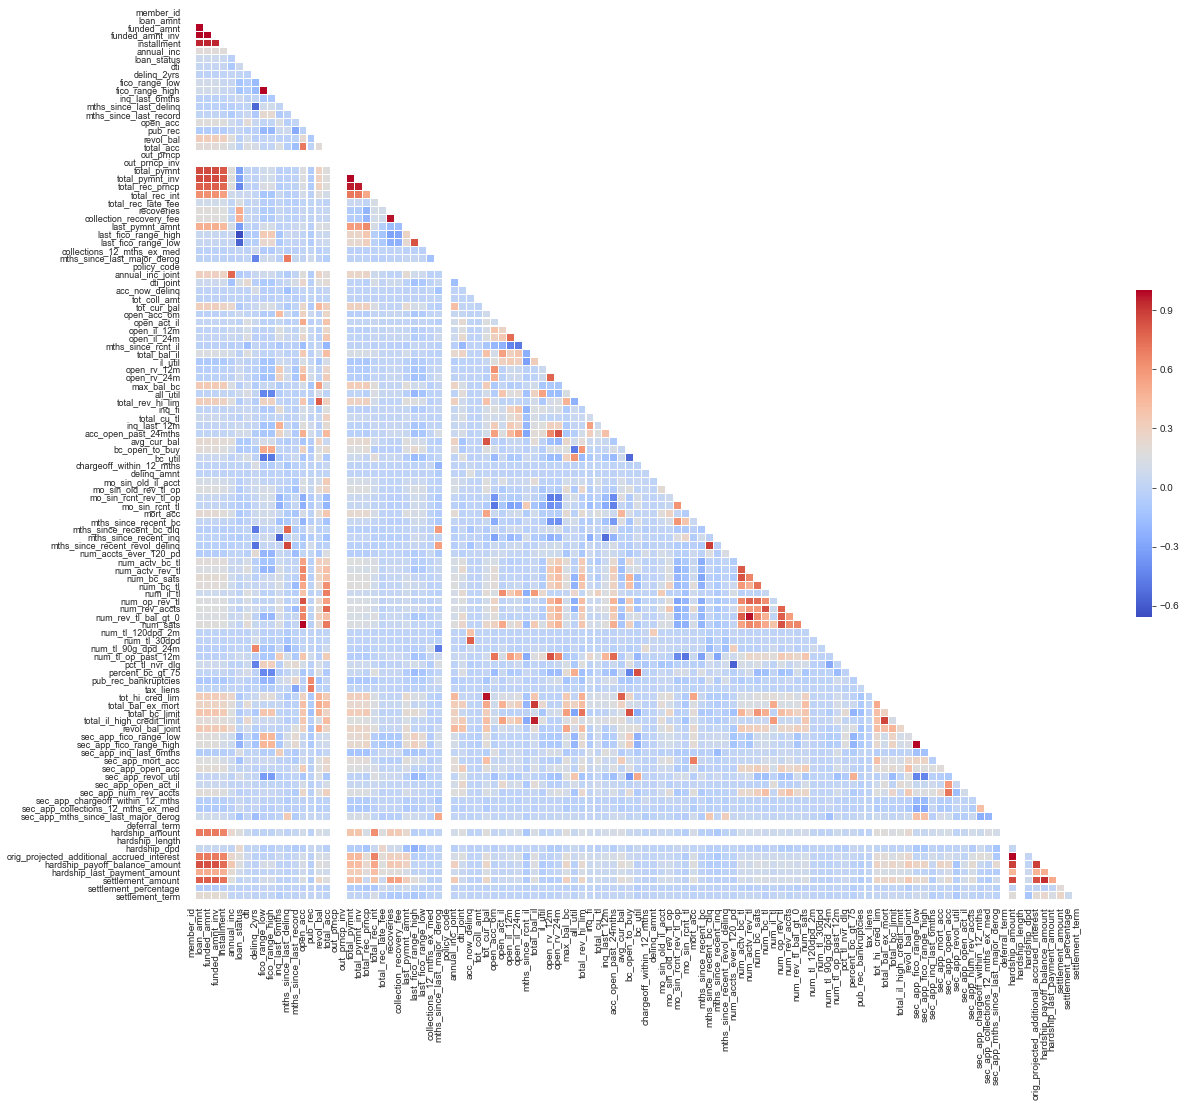

In [135]:
# plot correlation heatmap
plt.figure(figsize = (20, 20))
sns.set_style('whitegrid')
sns.heatmap(corr, mask = mask, cmap = 'coolwarm', linewidth = .05, square=True, cbar_kws={"shrink": .3},
           xticklabels = True, yticklabels = True)
plt.yticks(fontsize = 9)
plt.show()

<a id = 'notes'></a>
### 3. Notes:

**Observations:**
1. Sample portfolio - a case study of 300 loans in my portfolio selected by Lending Robot:
    1. Even F grades loans can be fully paid off.
    2. target variable = 'Status', only 'Charged Off' and 'Fully Paid' are considered for training.
    3. 30% default rate wipes out return from all other loans.

2. All loans:
    1. defaults highly correlate with borrower's credit worthiness;
    2. defaults highly correlate with grade given by issuer;
    3. Features include: borrower personal related such as employement and home ownership, borrower credit worthiness related such as credit score and dti, loan related such as amount and purpose; 
    4. slight higher default rate for renters versus other home ownership types;
    5. higher rate for small business versus personal reasons;
    6. loan amount related terms highly correlated, consider keeping one only;
    7. borrower's credit worthiness related terms highly correlated, as to be expected;


**Data Cleaning:**
1. Drop:
    1. Rows:
        1. 'loan_status': keep only 'Fully Paid' and 'Charged Off'
        2. 'grade': keep only A-D
        3. 'sub_grade': keep only A-D
        4. 'initial_list_status': keep only 'f'?
        5. keep one of ('loan_amnt','funded_amnt','funded_amnt_inv')?
    2. Columns:
        1. data leakage: compare with columns non-existent in the open loan data
        1. non-informational: 'id', 'url', 'desc',
        2. nlp: 'emp_title', 'desc', 'title',
        3. zero variance: 'pymnt_plan', 'member_id'
        4. geospatial: 'zip_code', 'addr_state'
2. Structural errors:
    1. cat -> num: 'int_rate', 'revol_util',
    2. cat -> ord: 'grade', 'sub_grade', 'emp_length', 'term',
    3. cat -> date: 'issue_d',  'earliest_cr_line','sec_app_earliest_cr_line',
3. Outliers:
Possible outliers based on histogram of numerical features, notice single bar charts with large value on x
axis, need further investigation, e.g., 'annual_inc', 'dti', 'revol_bal','total_acc','annual_inc_joint', 'tot_coll_amt','tot_cur_bal', 'open_acc_6m', 'max_bal_bc','total_rev_hi_lim', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'num_il_tl','tax_liens',  'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'all_util'
   
4. Missing values: exist, need to address, using correlation map for imputing rules.


**Feature Engineering:**
1. Group sparse:'home_ownership', 'purpose',
2. New feature: 'credit_history' = 'issue_d' - 'earliest_cr_line'
3. New feature: installment vs. income

**End of current notebook**

**[back to top](#toc)**

---


**Previous notebook: [part 0b - dataAggregation](proj-classification-loanDefault-p0b-dataAggregation-max-v2019Dec.ipynb)**

**Next notebook: [part 2 - dataCleaning+featureEngineering](proj-classification-loanDefault-p2-dataCleaning-featureEngineering-max-v20200225-remote.ipynb)**